# Gaussian Process Input Error Algorithms

In [61]:
import sys
sys.path.insert(0, '/Users/eman/Documents/code_projects/gp_error')
from gp_error.gaussianprocess import GPRegressor
from sklearn.gaussian_process.kernels import (ConstantKernel as C, RBF, WhiteKernel)
from gp_extras.kernels import HeteroscedasticKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from gp_error.gaussianprocess import GPUncertainty
from gp_error.data import example_1d
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Sample Data

/Users/eman/anaconda3/envs/gperror/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


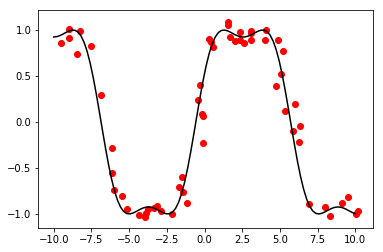

In [62]:
sample_func = 1
x_error = 0.3
X, y, error_params = example_1d(sample_func, x_error)

fig, ax = plt.subplots()
ax.scatter(X['train'], y['train'], color='r')
ax.plot(X['plot'], y['plot'], color='k')

plt.show()

## Experiment I - Error In Predictions

In [71]:
gp_models = dict()
predictions = dict()
standard_dev = dict()
mse = dict()
mae = dict()
rmse = dict()

### My GP Error Model (Enhanced Predictive Variance)

In [78]:
# My GP
mygp_clf = GPRegressor(x_covariance=error_params['x'])
mygp_clf.fit(X['train'], y['train'])
mean, std = \
    mygp_clf.predict(X['test'], return_std=True)

mse['var'] = mean_squared_error(mean, y['test'])
mae['var'] = mean_absolute_error(mean, y['test'])
print(mse['var'])
print(mae['var'])

0.030893258710912686
0.1195073117857016


In [50]:
%timeit mygp_clf.predict(X['plot'], return_std=True)

1.34 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [86]:
predictions['var'], standard_dev['var'] = \
    mygp_clf.predict(X['plot'], return_std=True)

In [84]:
def plot_gp(predictions, variances, X, title=None):
    
    fig, ax = plt.subplots()
    ax.scatter(X['train'], y['train'], color='r', label='Training Data')
    ax.plot(X['plot'], predictions, color='k', label='Predictions')
    ax.fill_between(
        X['plot'].squeeze(),
        predictions.squeeze() + 2*variances.squeeze(),
        predictions.squeeze() - 2*variances.squeeze(),
        color='red', alpha=0.2, label='Condidence'
    )
    ax.legend()
    plt.show()
    return None

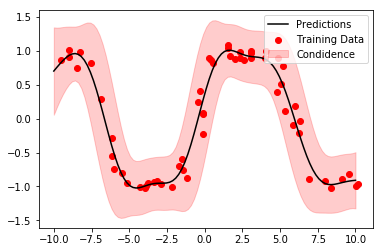

In [87]:
plot_gp(predictions['var'], standard_dev['var'], X)

### Scikit-Learn Gaussian Process Algorithm

In [88]:

# Their GP
kernel = C() * RBF() + WhiteKernel()
sk_gp_model = GaussianProcessRegressor(kernel=kernel)
sk_gp_model.fit(X['train'], y['train'])
sk_mean, sk_std = sk_gp_model.predict(X['plot'], return_std=True)

In [53]:
%timeit sk_gp_model.predict(X['plot'], return_std=True)

363 µs ± 91.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


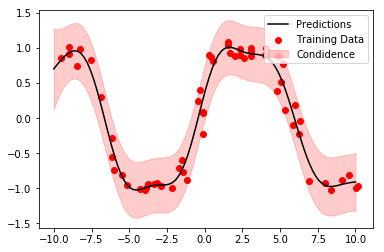

In [54]:
fig, ax = plt.subplots()

ax.scatter(X['train'], y['train'], color='r', label='Training Data')
ax.plot(X['plot'], sk_mean, color='k', label='Predictions')
ax.fill_between(
    X['plot'].squeeze(),
    sk_mean.squeeze() + 2*sk_std.squeeze(),
    sk_mean.squeeze() - 2*sk_std.squeeze(),
    color='red', alpha=0.2, label='Condidence'
)
ax.legend()
plt.show()

### Scikit-Learn Gaussian Process Algorithm (Heteroscedastic Noise Model)

In [55]:
# Their GP
prototypes = KMeans(n_clusters=10).fit(X['train']).cluster_centers_
kernel = C() * RBF() + HeteroscedasticKernel.construct(prototypes)
skh_gp_model = GaussianProcessRegressor(kernel=kernel)
skh_gp_model.fit(X['train'], y['train'])
skh_mean, skh_std = skh_gp_model.predict(X['plot'], return_std=True)

In [56]:
%timeit skh_gp_model.predict(X['plot'], return_std=True)

556 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


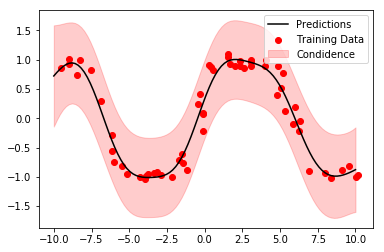

In [57]:
fig, ax = plt.subplots()

ax.scatter(X['train'], y['train'], color='r', label='Training Data')
ax.plot(X['plot'], skh_mean, color='k', label='Predictions')
ax.fill_between(
    X['plot'].squeeze(),
    skh_mean.squeeze() + 2*skh_std.squeeze(),
    skh_mean.squeeze() - 2*skh_std.squeeze(),
    color='red', alpha=0.2, label='Condidence'
)
ax.legend()
plt.show()

### Error Propagation (Approximate Integral)

In [58]:
gp_errmodel = GPUncertainty(x_error=x_error)
gp_errmodel.fit(X['train'], y['train']);
output_mean, out_std = gp_errmodel.predict(X['plot'])

In [59]:
%timeit gp_errmodel.predict(X['plot'])

274 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


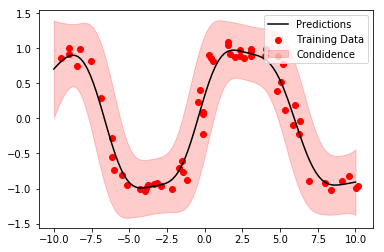

In [60]:
fig, ax = plt.subplots()

ax.scatter(X['train'], y['train'], color='r', label='Training Data')
ax.plot(X['plot'].squeeze(), output_mean, color='k', label='Predictions')
ax.fill_between(
    X['plot'].squeeze(),
    output_mean.squeeze() + 2*out_std.squeeze(),
    output_mean.squeeze() - 2*out_std.squeeze(),
    color='red', alpha=0.2, label='Condidence'
)
ax.legend()
plt.show()

## Empirical Variance